In [1]:
import numpy as np
import pandas as pd

# companies dataframe
# Using Palmos since, in this encoding foriegn language data is correctly changed and the match is proper against the equivalents
companies=pd.read_csv("companies.txt", sep="\t", encoding='Palmos')

# rounds2 dataframe
rounds2=pd.read_csv("rounds2.csv", sep=",", encoding= "Palmos")

print('*************Checkpoint 1-Data Cleaning 1********************************')

#Question 1
#Converting both company_permalink in rounds2 and permalink in companies to lower case so that the match would be proper for merge and also to find the unique companies
rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()
print(rounds2['company_permalink'].nunique()) # No. of unique companies in rounds2 df

#Question 2
companies['permalink'] = companies['permalink'].str.lower()
print(companies['permalink'].nunique()) # No. of unique companies in companies df

#Question 3- The Unique company list can be obtained from 'permalink' column of companies df
print('permalink')

#Question 4- Checking if any of the company from rounds2 is not present in company df. 
print(rounds2['company_permalink'].isin(companies['permalink']).value_counts())
#The result shows that all the companies in rounds2 are present in companies df

#Question 5- Merging the 2 dfs. Using how='left' to retain all the items from rounds2 df
master_frame = pd.merge(rounds2, companies, how = 'left', left_on = 'company_permalink', right_on = 'permalink')
print(len(master_frame)) #No. of observations(rows) in merged df


*************Checkpoint 1-Data Cleaning 1********************************
66368
66368
permalink
True    114949
Name: company_permalink, dtype: int64
114949


In [2]:
#Cleaning the data
#Checking for null values
master_frame.isnull().sum()

#Dropping the columns with null values and which are not needed for our analysis
# company_permalink and permalink contain the same values, hence dropping off permalink column
master_frame = master_frame.drop(['funding_round_code','homepage_url','state_code','region','city','founded_at','permalink'], axis = 1)

#Check once again for null values
master_frame.isnull().sum()

#It is observed that raised_amount_usd, category_list and country_code have high value of null count but these columns cant be dropped off since they are required for analysis
#Hence, dropping off rows based on null column count
master_frame = master_frame[~(master_frame['raised_amount_usd'].isnull() | master_frame['category_list'].isnull() | master_frame['country_code'].isnull())]

# Check for remaining rows in master_frame
print(len(master_frame)) # Final no. of rows retained in master_frame after data cleaning


88529


In [3]:
print('*************Checkpoint 2-Funding Type Analysis********************************')

#According to the requirement mentioned, consider only the specified 4 funding types for further analysis 
master_frame=master_frame[(master_frame['funding_round_type']=='venture')|(master_frame['funding_round_type']=='seed')|
                          (master_frame['funding_round_type']=='angel')|(master_frame['funding_round_type']=='private_equity')]

#calculating average investment amount for each of the four funding types.
master_frame['raised_amount_usd'] = master_frame['raised_amount_usd']/1000000

print(master_frame.groupby('funding_round_type').raised_amount_usd.mean())

# This is required for plotting the graph at the end
# Since, the master_frame will be altered to have only the best FT for further analysis
totalFunding = master_frame.groupby('funding_round_type').raised_amount_usd.agg('sum').sort_values(ascending=False).reset_index(name='Total_amt_of_investment')
averageFunding = master_frame.groupby('funding_round_type').raised_amount_usd.mean().sort_values(ascending=False).reset_index(name='Avg_amt_of_investment')

# "Venture" is the most suitable investment type for Spark Funds
master_frame =master_frame[master_frame['funding_round_type'] == 'venture']
print(len(master_frame))  # Final no. of rows retained in master_frame after retaining only Venture FT


*************Checkpoint 2-Funding Type Analysis********************************
funding_round_type
angel              0.971574
private_equity    73.938486
seed               0.747794
venture           11.724223
Name: raised_amount_usd, dtype: float64
47809


In [4]:
print('*************Checkpoint 3-Country Analysis********************************')

top9  = master_frame.groupby('country_code')['raised_amount_usd'].sum().sort_values(ascending=False).reset_index(name='Total_amount')
top9 = top9.head(9)
print(top9)
#Hence, USA, CHN and GBR are top 3 but CHN is not in the list of english speaking countries, so the top 3 are USA, GBR and IND

# consider only the rows based on the top 3 countries for further analysis
master_frame = master_frame[(master_frame['country_code'] == 'USA')|(master_frame['country_code'] == 'GBR')|(master_frame['country_code'] == 'IND')]
print(len(master_frame)) # Final no. of rows retained in master_frame after retaining only top 3 countries

*************Checkpoint 3-Country Analysis********************************
  country_code   Total_amount
0          USA  420068.029342
1          CHN   39338.918773
2          GBR   20072.813004
3          IND   14261.508718
4          CAN    9482.217668
5          FRA    7226.851352
6          ISR    6854.350477
7          DEU    6306.921981
8          JPN    3167.647127
38803


In [5]:
print('*************Checkpoint 4-Sector Analysis 1********************************')

#Extract the primary sector from category_list in master_frame
master_frame['category_list'] = master_frame['category_list'].apply(lambda x: x.split('|')[0])
master_frame.rename(columns={'category_list':'primary_sector'}, inplace=True)

#mapping dataframe
mapping = pd.read_csv('mapping.csv', sep=",", encoding= "palmos")
mapping['category_list'] = mapping['category_list'].replace('0','na',regex=True)

# In the above step '0' is changed to 'na'. 
#There is an entry 'Enterprise 2.0' in mapping df, the '0' in this'2.0' is changed to '2.na'. Hence, changing it back to '2.0'
mapping['category_list'] = mapping['category_list'].replace('2.na','2.0',regex=True)

#'0' to 'na' changes '0notechnology' to 'nanotechnology' but in master_frame it is 'Nanotechnology' which will lead to a mismatch while merging
# Hence, replacing below ones so that these are not lost during merge with master_frame
mapping['category_list'] = mapping['category_list'].replace({'nanotechnology':'Nanotechnology',
                                                      'natural Language Processing':'Natural Language Processing',
                                                      'natural Resources':'Natural Resources',
                                                      'navigation':'Navigation'},regex=True)

#Converting column matrix to row matrix (i.e., wide to long df)
mapping = mapping.melt(id_vars=['category_list'],value_vars=['Automotive & Sports','Blanks','Cleantech / Semiconductors',
                                                             'Entertainment','Health','Manufacturing',
                                                             'News, Search and Messaging','Others',
                                                             'Social, Finance, Analytics, Advertising'],var_name="main_sector") 
mapping = mapping[~(mapping.value == 0)] # retain only rows where there is a main sector for category_list
mapping = mapping.drop('value',axis = 1) # remove the value column, it is no longer required
print(mapping.head())

#merge mapping df with master_frame
master_frame = pd.merge(master_frame,mapping, how = 'left', left_on ='primary_sector',right_on ='category_list')
master_frame.head()

#List of primary sectors which have no main sectors in the master_frame
master_frame[master_frame.main_sector.isnull()].category_list.unique()

#Consider only the rows which have main_sector values
master_frame = master_frame[~(master_frame.main_sector.isnull())]
print(len(master_frame.index))



*************Checkpoint 4-Sector Analysis 1********************************
       category_list          main_sector
8   Adventure Travel  Automotive & Sports
14         Aerospace  Automotive & Sports
45              Auto  Automotive & Sports
46   Automated Kiosk  Automotive & Sports
47        Automotive  Automotive & Sports
38792


In [6]:
print('*************Checkpoint 5-Sector Analysis 2********************************')

D1 = master_frame[(master_frame['country_code'] == 'USA') & 
             (master_frame['raised_amount_usd'] >= 5) & (master_frame['raised_amount_usd'] <= 15)]
D1a=D1.groupby('main_sector').raised_amount_usd.agg(['sum','count']).rename(columns={'sum':'Total_amount','count':'Total_count'})
D1 = pd.merge(D1,D1a, how='left', left_on ='main_sector', right_on ='main_sector')


D2 = master_frame[(master_frame['country_code'] == 'GBR') & 
             (master_frame['raised_amount_usd'] >= 5) & (master_frame['raised_amount_usd'] <= 15)]
D2a=D2.groupby('main_sector').raised_amount_usd.agg(['sum','count']).rename(columns={'sum':'Total_amount','count':'Total_count'})
D2 = pd.merge(D2,D2a, how='left', left_on ='main_sector', right_on ='main_sector')


D3 = master_frame[(master_frame['country_code'] == 'IND') & 
             (master_frame['raised_amount_usd'] >= 5) & (master_frame['raised_amount_usd'] <= 15)]
D3a=D3.groupby('main_sector').raised_amount_usd.agg(['sum','count']).rename(columns={'sum':'Total_amount','count':'Total_count'})
D3 = pd.merge(D3,D3a, how='left', left_on ='main_sector', right_on ='main_sector')


#Total number of investments
print(D1.raised_amount_usd.count())
print(D2.raised_amount_usd.count())
print(D3.raised_amount_usd.count())

#Total sum of investment
print(round(D1.raised_amount_usd.sum(), 2))
print(round(D2.raised_amount_usd.sum(), 2))
print(round(D3.raised_amount_usd.sum(), 2))

print(D1a)
print(D2a)
print(D3a)

#USA-Others-top company
company = D1[D1['main_sector']=='Others']
company=company.groupby('company_permalink').raised_amount_usd.agg('sum').sort_values(ascending=False)
print(company.head(1))

#USA-Social,Finance,Analytics,Advertising-second top
company = D1[D1['main_sector']=='Social, Finance, Analytics, Advertising']
company=company.groupby('company_permalink').raised_amount_usd.agg('sum').sort_values(ascending=False)
print(company.head(1))

#GBR-Others-top company
company = D2[D2['main_sector']=='Others']
company=company.groupby('company_permalink').raised_amount_usd.agg('sum').sort_values(ascending=False)
print(company.head(1))

#GBR-Social,Finance,Analytics,Advertising-second top
company = D2[D2['main_sector']=='Social, Finance, Analytics, Advertising']
company=company.groupby('company_permalink').raised_amount_usd.agg('sum').sort_values(ascending=False)
print(company.head(1))

#IND-Others-top company
company = D3[D3['main_sector']=='Others']
company=company.groupby('company_permalink').raised_amount_usd.agg('sum').sort_values(ascending=False)
print(company.head(1))

#IND-Social,Finance,Analytics,Advertising-second top
company = D3[D3['main_sector']=='Social, Finance, Analytics, Advertising']
company=company.groupby('company_permalink').raised_amount_usd.agg('sum').sort_values(ascending=False)
print(company.head(1))



*************Checkpoint 5-Sector Analysis 2********************************
12063
621
328
107757.1
5379.08
2949.54
                                         Total_amount  Total_count
main_sector                                                       
Automotive & Sports                       1454.104361          167
Cleantech / Semiconductors               21633.430822         2350
Entertainment                             5099.197982          591
Health                                    8211.859357          909
Manufacturing                             7258.553378          799
News, Search and Messaging               13971.567428         1583
Others                                   26321.007002         2950
Social, Finance, Analytics, Advertising  23807.376964         2714
                                         Total_amount  Total_count
main_sector                                                       
Automotive & Sports                        167.051565           16
Cleantech / Se

<Figure size 432x288 with 0 Axes>

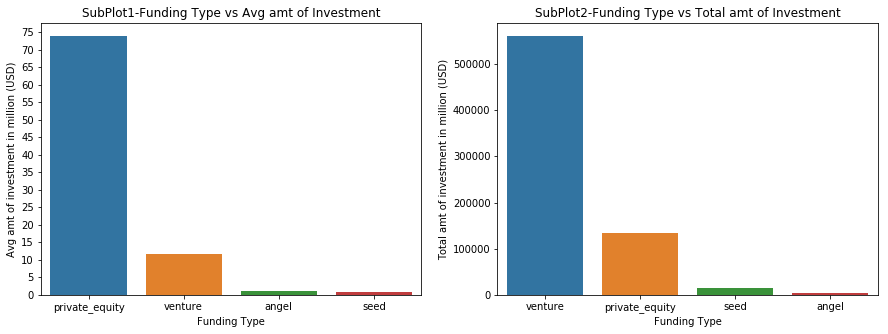

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(1)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.yticks(np.arange(0, 80, 5))
p = sns.barplot(x='funding_round_type', y='Avg_amt_of_investment', data=averageFunding)
plt.xlabel('Funding Type')
plt.ylabel('Avg amt of investment in million (USD)')
plt.title('SubPlot1-Funding Type vs Avg amt of Investment')

plt.subplot(122)
p = sns.barplot(x='funding_round_type', y='Total_amt_of_investment', data=totalFunding)
plt.xlabel('Funding Type')
plt.ylabel('Total amt of investment in million (USD)')
plt.title('SubPlot2-Funding Type vs Total amt of Investment')

plt.show()

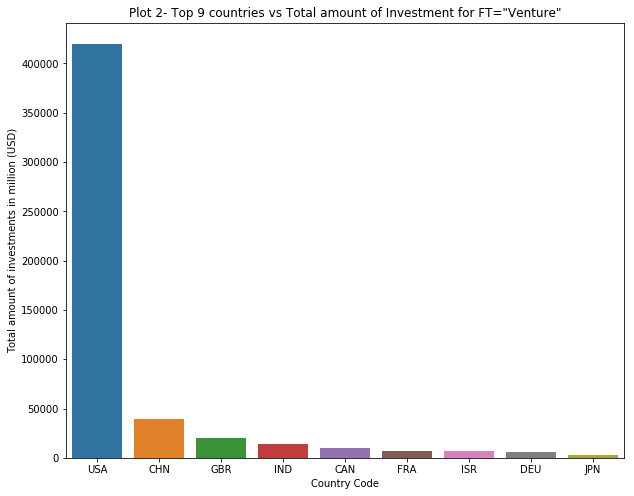

In [9]:
plt.figure(figsize=(10,8))
p = sns.barplot(x='country_code', y='Total_amount',data=top9)
plt.xlabel('Country Code')
plt.ylabel('Total amount of investments in million (USD)')
plt.title('Plot 2- Top 9 countries vs Total amount of Investment for FT="Venture"')
plt.show()

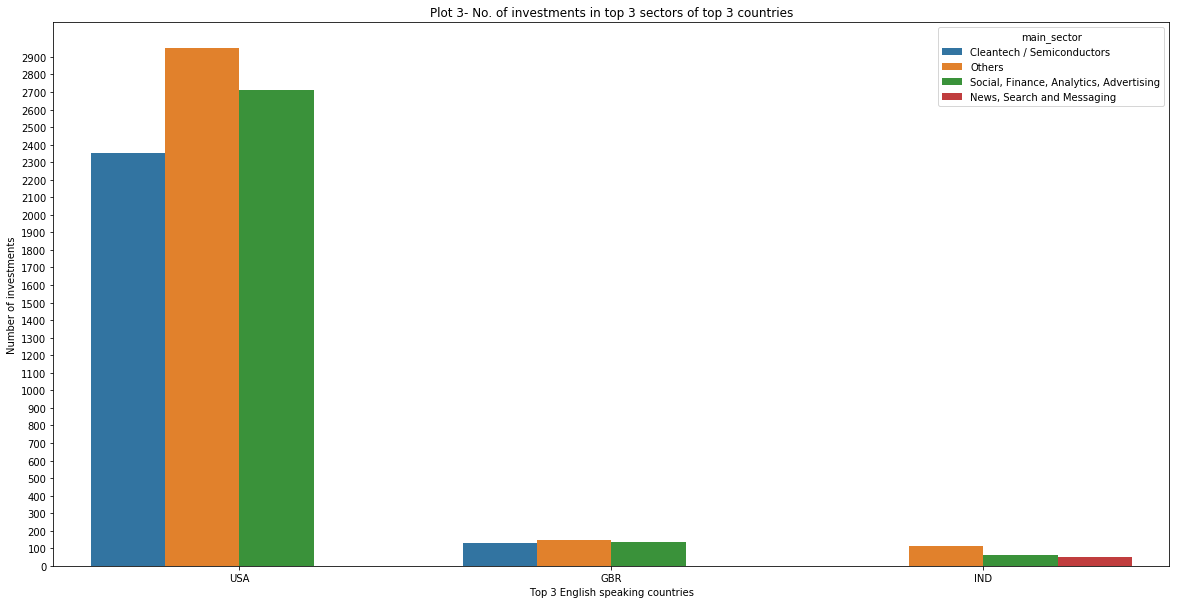

In [10]:
D1a['Country']="USA"
D2a['Country']="GBR"
D3a['Country']="IND"

D1a['main_sector']=D1a.index
D2a['main_sector']=D2a.index
D3a['main_sector']=D3a.index

D1a=D1a[(D1a['main_sector']=='Others')| (D1a['main_sector']=='Social, Finance, Analytics, Advertising')|(D1a['main_sector']=='Cleantech / Semiconductors')]
D2a=D2a[(D2a['main_sector']=='Others')| (D2a['main_sector']=='Social, Finance, Analytics, Advertising')|(D2a['main_sector']=='Cleantech / Semiconductors')]
D3a=D3a[(D3a['main_sector']=='Others')| (D3a['main_sector']=='Social, Finance, Analytics, Advertising')|(D3a['main_sector']=='News, Search and Messaging')]

plt.figure(figsize=(20, 10))
plt.yticks(np.arange(0, 3000, 100))
frames = [D1a, D2a, D3a]
result = pd.concat(frames)

p = sns.barplot(x='Country', y='Total_count', hue='main_sector', data=result)
plt.xlabel('Top 3 English speaking countries')
plt.ylabel('Number of investments')
plt.title('Plot 3- No. of investments in top 3 sectors of top 3 countries')

plt.show()